<a href="https://colab.research.google.com/github/joyarup/UCI-HAR-Clustering/blob/main/ML_MP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
!pip install ipython-autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.5 MB/s eta 0:00:00


In [3]:
X_train= pd.DataFrame(np.loadtxt(r'/content/X_train.txt'))


In [4]:
#size of dataset
X_train.shape

(7352, 561)

In [5]:
#sample of data
X_train.sample(1)

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
5410,0.261315,-0.026413,-0.129239,-0.562278,-0.147572,-0.494145,-0.589499,-0.168407,-0.503029,-0.494904,...,0.169807,0.216373,-0.053891,0.24827,0.711168,-0.357218,0.223418,-0.861548,0.174512,-0.042606


In [6]:
#check missing values
X_train.isnull().sum().sum()

0

In [7]:
#Let's see if the features differ in scale.
std = np.std(X_train, axis=1) # calculate the standard deviation for each feature
# compare the standard deviations
if np.max(std) - np.min(std) > 0.1:
    print("The features differ in scale.")
else:
    print("The features do not differ in scale.")

The features differ in scale.


In [8]:
#let's see difference of std for for features
std_diff= np.max(std)- np.min(std)
std_diff

0.18036178044381762

In [9]:
#Let's set the threshold for deviation equal to the deviation between the maximum and minimum standard deviations of the features.
threshold = 0.01 #(10% of features, approximately 56 features)
selector = VarianceThreshold(threshold=threshold)

#apply the method to the dataset
X_train_selected = selector.fit_transform(X_train)

#the result will be a dataset with reduced dimensionality
print(X_train_selected.shape)

(7352, 524)


In [10]:
#make standartization of data
scaler= StandardScaler()
X_train_scl= scaler.fit_transform(X_train_selected)

In [11]:
pd.DataFrame(X_train_scl).sample()#let's see result


,0,1,2,3,4,5,6,7,8,9,...,514,515,516,517,518,519,520,521,522,523
7030,-0.802467,-0.916174,-0.857552,-0.808261,-0.924243,-0.874313,-0.793377,-0.909539,-0.737035,0.714362,...,-2.478692,0.525297,0.119852,0.350699,1.486034,-0.190723,0.742143,1.947018,-1.522181,-1.989922


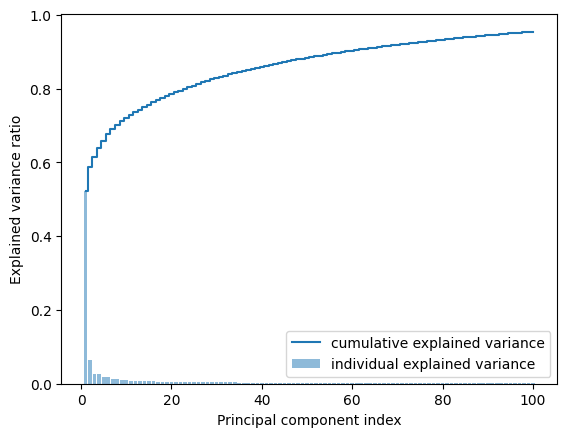

In [12]:
%timeit
pca= PCA(n_components=100)
pca.fit(X_train_scl)

# receive explainasion dispersion for each component
explained_variance = pca.explained_variance_ratio_

cum_var_exp = np.cumsum(explained_variance)

plt.bar(range(1, 101), explained_variance, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1, 101), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [14]:
#Let's calculate this number using the formula, taking into account that indices start from 0, we will add 1.
components = np.argmax(np.cumsum(explained_variance) >= 0.9) + 1

print('The number of components where the variance explained will be equal to 0.9:', components)

The number of components where the variance explained will be equal to 0.9: 59


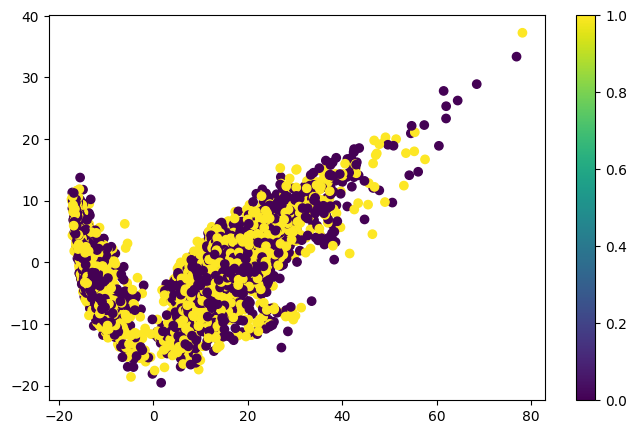

In [15]:
#choose first 2 components and make visualization
pca_2= PCA(n_components=2)
#aplly model to data
pca_data= pca.fit_transform(X_train_scl)

# create visualization
colors=np.random.randint(0, 2, size=7352)
plt.figure(figsize=(8,5))
plt.scatter(pca_data[:,0], pca_data[:,1], c=colors)
plt.colorbar()
plt.show()

## DBSCAN

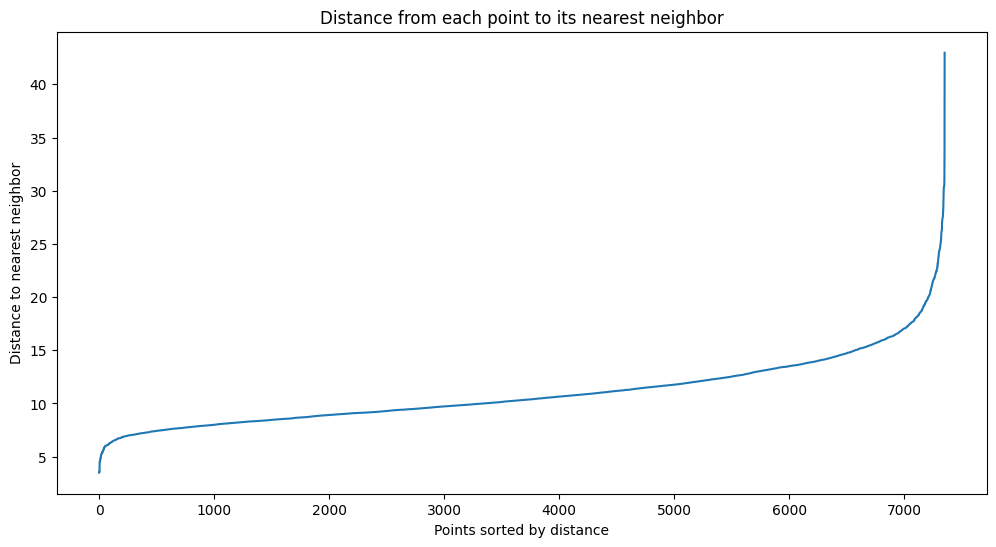

In [16]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train_scl is your scaled dataset
X = X_train_scl

# Use NearestNeighbors to find the distance to the nearest point
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sort distances
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot the distances
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.title("Distance from each point to its nearest neighbor")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to nearest neighbor")
plt.show()


In [23]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
%load_ext autotime
# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train_scl)

# Apply DBSCAN again with the chosen parameters (assuming you've chosen eps and min_samples)
dbscan = DBSCAN(eps=6, min_samples=2)  # Use your determined eps and min_samples values
clusters = dbscan.fit_predict(X_reduced)
# You can check the unique clusters formed
unique_clusters = np.unique(clusters)
print(f"Number of clusters: {len(unique_clusters)}")
print(f"Cluster labels: {unique_clusters}")

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Number of clusters: 2
Cluster labels: [0 1]
time: 1.33 s (started: 2024-03-12 11:52:06 +00:00)


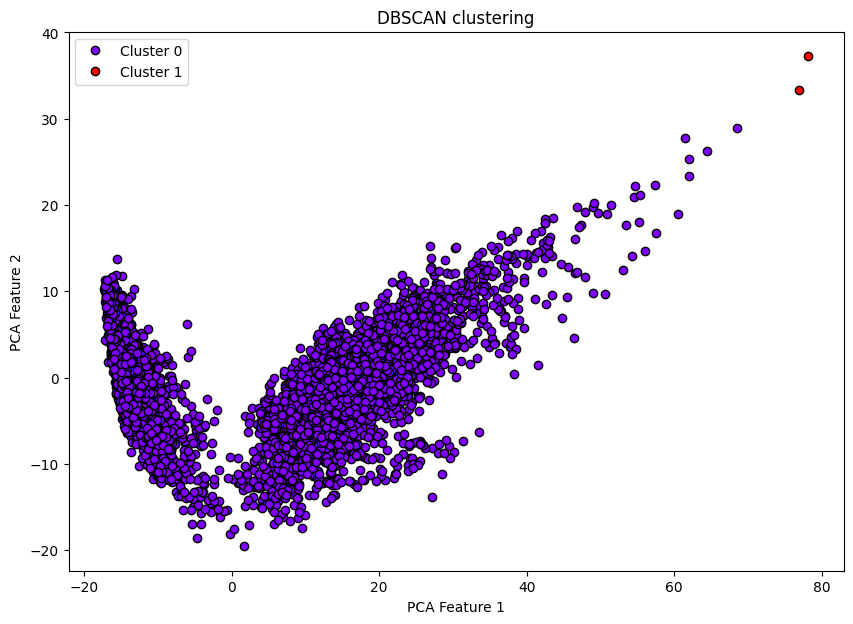

time: 557 ms (started: 2024-03-12 11:52:09 +00:00)


In [24]:
import matplotlib.pyplot as plt

# Plot each cluster with a different color
plt.figure(figsize=(10, 7))

# Scatter plot of the reduced data with cluster assignment
unique_labels = set(clusters)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (clusters == k)

    xy = X_reduced[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6, label=f'Cluster {k}')

plt.title('DBSCAN clustering')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend(loc='best')
plt.show()


In [26]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
%load_ext autotime
# Reduce dimensions to 2 for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(X_train_scl)

# Apply DBSCAN again with the chosen parameters (assuming you've chosen eps and min_samples)
dbscan = DBSCAN(eps=7, min_samples=2)  # Use your determined eps and min_samples values
clusters = dbscan.fit_predict(tsne_data)
# You can check the unique clusters formed
unique_clusters = np.unique(clusters)
print(f"Number of clusters: {len(unique_clusters)}")
print(f"Cluster labels: {unique_clusters}")

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
Number of clusters: 9
Cluster labels: [0 1 2 3 4 5 6 7 8]
time: 1min 13s (started: 2024-03-12 11:53:23 +00:00)


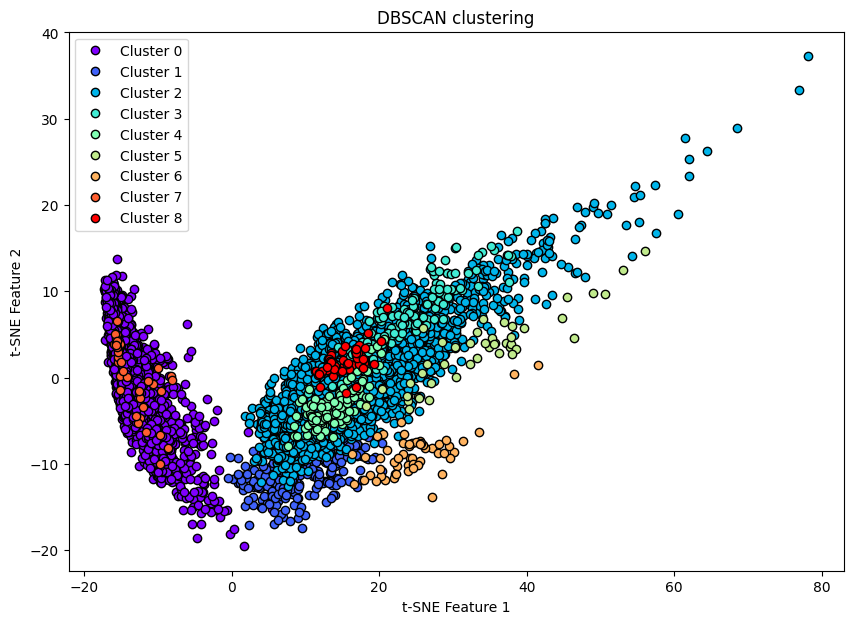

time: 436 ms (started: 2024-03-12 11:54:52 +00:00)


In [27]:
import matplotlib.pyplot as plt

# Plot each cluster with a different color
plt.figure(figsize=(10, 7))

# Scatter plot of the reduced data with cluster assignment
unique_labels = set(clusters)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (clusters == k)

    xy = X_reduced[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6, label=f'Cluster {k}')

plt.title('DBSCAN clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(loc='best')
plt.show()


## KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

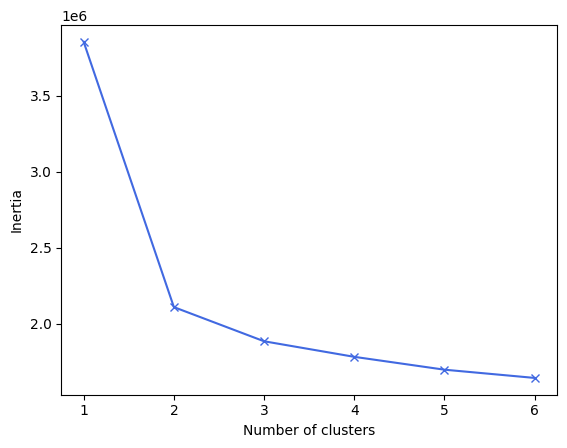

time: 16.4 s (started: 2024-03-12 11:55:08 +00:00)


In [28]:
# Determine the optimal number of clusters using the elbow method
# Create a list to store the values of the objective function
inertia = []
k_range = range(1, 7)

# Use a loop to iterate over the number of clusters from 1 to 6
for k in k_range:
    # Create an instance of the KMeans model with the current number of clusters
    kmeans = KMeans(n_clusters=k)
    # Train the model on the data
    kmeans.fit(X_train_scl)
    # Add the value of the objective function to the list
    inertia.append(kmeans.inertia_)

# Plot the dependency graph of the value of the objective function on the number of clusters
plt.plot(k_range, inertia, c='royalblue', marker='x')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [29]:
# Assign the value of the optimal number of K clusters to a variable
optimal_k= 2

time: 797 µs (started: 2024-03-12 11:55:45 +00:00)


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


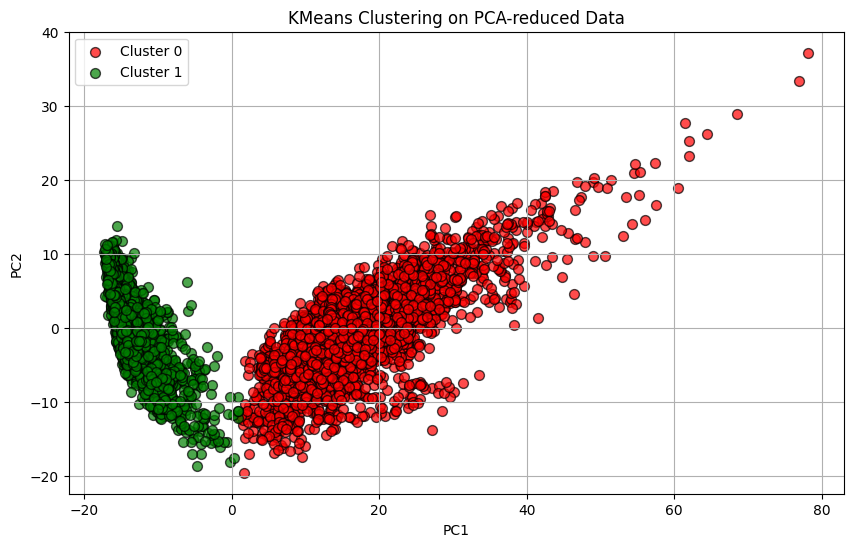

time: 4.44 s (started: 2024-03-12 12:01:00 +00:00)


In [33]:
%load_ext autotime
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(X_train_scl)
target = kmeans.labels_

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_train_scl)

# plot
plt.figure(figsize=(10, 6))  # Making the figure larger for better visibility
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']  # More colors for differentiation
# Ensure you have enough colors for each cluster, or use a colormap

# Loop through labels and plot each cluster
for i, color in zip(range(optimal_k), colors):
    plt.scatter(pca_data[target == i, 0], pca_data[target == i, 1],
                color=color, label=f'Cluster {i}',
                alpha=0.7, edgecolors='k', s=50)  # Alpha for transparency, edgecolors for distinction

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering on PCA-reduced Data')
plt.legend()  # Show legend
plt.grid(True)  # Adding a grid for better readability
plt.show()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


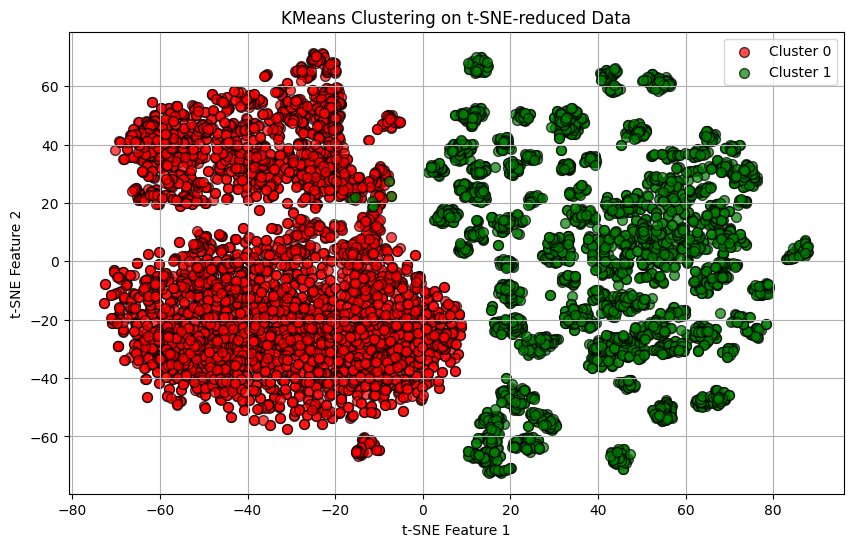

time: 1min 12s (started: 2024-03-12 12:01:26 +00:00)


In [34]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%load_ext autotime
# Assuming optimal_k is already determined and X_train_scl is your scaled dataset
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(X_train_scl)
target = kmeans.labels_

tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(X_train_scl)

# plot
plt.figure(figsize=(10, 6))  # Larger figure for better visibility
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']  # More colors for differentiation
# Ensure you have enough colors for each cluster or use a colormap

# Loop through labels and plot each cluster
for i, color in zip(range(optimal_k), colors):
    plt.scatter(tsne_data[target == i, 0], tsne_data[target == i, 1],
                color=color, label=f'Cluster {i}',
                alpha=0.7, edgecolors='k', s=50)  # Alpha for transparency, edgecolors for distinction

plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.title('KMeans Clustering on t-SNE-reduced Data')
plt.legend()  # Show legend
plt.grid(True)  # Adding a grid for better readability
plt.show()


In [ ]:
y_train=np.loadtxt(r'/content/y_train.txt', dtype=int)

In [ ]:
y_train

array([5, 5, 5, ..., 2, 2, 2])

In [ ]:
activity_labels = np.loadtxt(r'/content/activity_labels.txt', dtype=str)

activity_labels

array([['1', 'WALKING'],
       ['2', 'WALKING_UPSTAIRS'],
       ['3', 'WALKING_DOWNSTAIRS'],
       ['4', 'SITTING'],
       ['5', 'STANDING'],
       ['6', 'LAYING']], dtype='<U18')

In [ ]:
# Create a contingency table where the rows represent real activities and the columns represent cluster labels.
contingency_table = np.zeros((len(y_train), optimal_k), dtype=int)

# Fill in the contingency table
for i in range(len(y_train)):
    contingency_table[i,0] = y_train[i]
    contingency_table[i,1] = target[i]

# Convert to a dataframe
df= pd.DataFrame(contingency_table, columns=['real_labels', 'clusters'])

In [ ]:
df.sample(5)


,real_labels,clusters
3409,2,0
1049,6,1
5514,4,1
3783,3,0
3774,2,0


In [ ]:
df.value_counts()


real_labels  clusters
6            1           1396
5            1           1374
4            1           1285
1            0           1226
2            0           1066
3            0            986
6            0             11
2            1              7
4            0              1
dtype: int64